![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQqTVdFA4dLpy2gesQruhxt2Cq48T6OLe7nE9jcnQCn8WFpwaAs)
![](https://1.bp.blogspot.com/-mylooQ1NvrA/UoMdk_M49uI/AAAAAAAAEq8/r9x7o9sC-q4/s1600/UFC1-RoyceXArt-02-400-kick-sg.gif)

# 1. Introduction

Hello everyone, this my analysis of UFC Historical data from 1993 to 2019.<br>
I will make an Exploratory Data Analysis, Feature Engineering and predict the winner using the cleaned data provided by the dataset author. Maybe in the future I will make a Kernel with my data cleaning.<br>
The Predictions will be made with [Catboost](https://catboost.ai/) Classifier.
Let's see what files the dataset contains and import [fastai](https://www.fast.ai/) to use Pandas, Numpy and a lot of useful Python Modules, this module rocks.

In [1]:
from fastai.imports import *
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ufcdata/raw_total_fight_data.csv
/kaggle/input/ufcdata/preprocessed_data.csv
/kaggle/input/ufcdata/data.csv
/kaggle/input/ufcdata/raw_fighter_details.csv


As said early, I will use the data cleaned, time to import it.

In [2]:
DATA_PATH = '../input/ufcdata/'
data = pd.read_csv(DATA_PATH+'data.csv')

Let's check how many features the author got with his Feature Engineering, how many samples it have, if there is any missing values and take a look on the dataset values.

# 2. Exploratory Data Analysis (EDA)

In [3]:
missing = data.isnull().sum().sort_values(ascending=False)
print(f'Number of Features in data with missing values: {len(missing[missing > 0])}\n')
print(missing[missing > 0])
data.head(3)

Number of Features in data with missing values: 109

B_avg_opp_DISTANCE_att     1265
B_avg_TD_pct               1265
B_avg_opp_TD_att           1265
B_avg_opp_TD_landed        1265
B_avg_opp_TOTAL_STR_att    1265
                           ... 
Referee                      23
B_Height_cms                  8
B_Weight_lbs                  6
R_Height_cms                  4
R_Weight_lbs                  3
Length: 109, dtype: int64


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0


A look into dataset memory size.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


And check what features are categorical.

In [5]:
list(data.select_dtypes(include=['object']))

['R_fighter',
 'B_fighter',
 'Referee',
 'date',
 'location',
 'Winner',
 'weight_class',
 'B_Stance',
 'R_Stance']

To visualize the results of EDA, I will use [Plotly](https://plot.ly/python/), it is a cool Python module that plot interactive and high quality graphics.

In [6]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

To start the job, I will see the distribution of Winners by Corner Color, this the feature that define the winner. It's useful to check any class imbalance.

In [7]:
values = data.Winner.value_counts()
labels = data.Winner.unique()
colors = ['red', 'blue', 'green']
trace = go.Pie(labels=labels, 
               values=values,
                marker=dict(colors=colors) 
              )
layout = go.Layout(title='Winner Distribution by Corner Color')
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

Another good information to extract is what countries have the most number of events. It's useful because sponsors could decide in which country they can invest with UFC Trademark.

In [8]:
data['country'] = data['location'].apply(lambda x : x.split(',')[-1])
values = data['country'].value_counts().sort_values(ascending=False).head(10)
labels = values.index
trace = go.Bar(y=values, x=labels)
layout = go.Layout(title='Top 10 Countries with events', 
                   xaxis={'title':'Country'},
                  yaxis={'title' : 'Events'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

Let's check how many fighters are analyzed and the fighters with most participation on UFC matches.

In [9]:
fighters = pd.concat([data['R_fighter'], data['B_fighter']], ignore_index=True)
print(f'There are {len(fighters.unique())} fighters in the dataset.')

values = fighters.value_counts().sort_values(ascending=False).head(10)
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Top 10 Fighters in Matches',
                  xaxis = {'title' : 'Fighters'},
                  yaxis = {'title' : 'Number of Matches'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

There are 1915 fighters in the dataset.


Donald Cerrone and Jim Miller get the top with 32 participations in events fight.<br>
It's time to see how UFC have made events by the years.

In [10]:
data['year'] = data['date'].apply(lambda x : x.split('-')[0])
values = data['year'].value_counts().sort_values(ascending=False)
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Number of Fights by Year (1993-2019)',
                  xaxis = {'title' : 'Year'},
                  yaxis = {'title' : 'Number of Matches'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

One good insight to get is the Age distribution by Fighters.

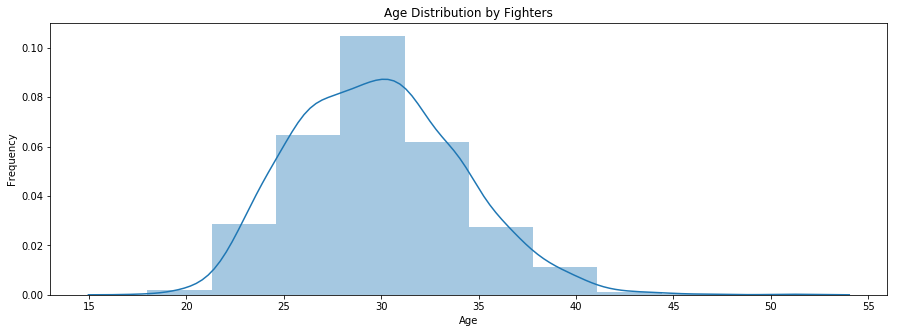

In [11]:
plt.rcParams['figure.figsize'] = (15,5)
df_rage = data[['R_fighter','R_age']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = data[['B_fighter', 'B_age']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)
sns.distplot(df_aux['age'], bins=10)
plt.title('Age Distribution by Fighters')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Let's check de oldest UFC Fighter in the dataset.

In [12]:
print(df_aux.groupby('age').max().tail(1))

            fighter
age                
51.0  Ron van Clief


And the youngest.

In [13]:
print(df_aux.groupby('age').min().head(1))

             fighter
age                 
18.0  Sean Daugherty


The mean age is around 30, but let's investigate more, see the mean age distribution by year.

In [14]:
df_rage = data[['R_fighter','R_age','year']].copy()
df_rage = df_rage.rename(columns={'R_fighter' : 'fighter', 'R_age' : 'age'})
df_bage = data[['B_fighter', 'B_age','year']].copy()
df_bage = df_bage.rename(columns={'B_fighter' : 'fighter', 'B_age' : 'age'})
df_aux = df_rage.append(df_bage, sort=False, ignore_index=True)
df_aux.drop_duplicates(subset='fighter', keep='first', inplace=True)
df_aux = df_aux.groupby('year')['age'].mean()
values = df_aux
labels = values.index
trace = go.Bar(x=labels, y=values)
layout = go.Layout(title='Mean Age distribution by Year (1993-2019)',
                  xaxis = {'title' : 'Year'},
                  yaxis = {'title' : 'Mean Age'})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

This conclude my EDA, maybe in the future I will explore more variables, but for now it is enough to get good insights about the datasets.

# 3. Feature Engineering (FE)

A lot of FE was done by the Dataset author, he have created so many features to work and cleaned the dataset, thanks dude!<br>
First, let's check again the dataset, extract target variable and drop useless features.

In [15]:
data.head(3)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,country,year
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,...,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0,USA,2019
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,...,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0,USA,2019
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,...,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0,USA,2019


Time to extract the target column I will predict the Winner.<br>
I created two more, country and year, and they have enough information to build a model, hence I will drop location and date.

In [16]:
target = data['Winner'].copy()
data = data.drop(columns=['date','location'])
print(f'The dataset have {data.shape[1]} features now.')

The dataset have 145 features now.


145 Features seems too much, but remember that the author have done some Feature engineering and adding this new two columns and dropping the old two seems engouh.<br>
Now I will make a label enconder on the target variable, we have three classes: Draw, Red (Winner) and Blue (Winner).

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
target = le.fit_transform(target.values)

The split in Train (70%) and Test (30%) to evaluate the model.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=42)
print(f'Input Train Shape {x_train.shape}')
print(f'Output Train Shape {y_train.shape}')
print(f'Input Test Shape {x_test.shape}')
print(f'Output Test Shape {y_test.shape}')

Input Train Shape (3600, 145)
Output Train Shape (3600,)
Input Test Shape (1544, 145)
Output Test Shape (1544,)


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=42)
print(f'Input Train Shape {x_train.shape}')
print(f'Output Train Shape {y_train.shape}')
print(f'Input Test Shape {x_test.shape}')
print(f'Output Test Shape {y_test.shape}')

Convert all NAs to value -999, some machine learning algorithms can identify NAs with this value.

In [19]:
x_train = x_train.fillna(-999)
x_test = x_test.fillna(-999)

First, I will build a simple model with Catboost to see the predicitions with all features.

# 4. Model

To make this task, I will build a model using Catboost classifier and check the model prediction with Precision, Recall and F1-Score.<br>
Catboost is a good choice when we have too many categorical values on the features, it can handle without label encoder. <br>
Get which features are categorical and store it on vector.

In [20]:
cat_features = np.where(x_train.dtypes != float)[0]

And now build the model, as the model have just around 5000 samples, CPU is enough to run the model.

In [21]:
# Create CatBoost as Model
from catboost import CatBoostClassifier

model = CatBoostClassifier(task_type="CPU",
                             learning_rate=0.1, 
                             iterations=100, 
                             l2_leaf_reg=4,
                             random_seed=42, 
                             od_type="Iter",
                             depth=8, 
                             silent=True)

And now time to train and test the model.

In [22]:
%%time
from sklearn.metrics import precision_score, recall_score, f1_score

model.fit(x_train, y_train, cat_features=cat_features)
train_pred = model.predict(x_train)
precision = precision_score(y_train, train_pred, average='weighted')
recall = recall_score(y_train, train_pred, average='weighted')
f1score = f1_score(y_train, train_pred, average='weighted')
print(f'Precision (Train): {precision}')
print(f'Recall (Train): {recall}')
print(f'F1-Score (Train): {f1score}')
test_pred = model.predict(x_test)
precision = precision_score(y_test, test_pred, average='weighted')
recall = recall_score(y_test, test_pred, average='weighted')
f1score = f1_score(y_test, test_pred, average='weighted')
print(f'Precision (Test): {precision}')
print(f'Recall (Test): {recall}')
print(f'F1-Score (Test): {f1score}')

Precision (Train): 1.0
Recall (Train): 1.0
F1-Score (Train): 1.0
Precision (Test): 1.0
Recall (Test): 1.0
F1-Score (Test): 1.0
CPU times: user 39.9 s, sys: 1.02 s, total: 40.9 s
Wall time: 11.1 s


Wow! What a score! Catboost could handle the problem with a simple model with few estimators in a few time.<br>
There's no need to train a second model.

# 5. Conclusion

The analysis and machine learning model were sucessfull, with the Catboost Classifier Model getting 1.0 in all the metrics. <br>
For Future work, it's good to make more EDA to analyze more Features relationship.<br>
Thanks for the reading!
